
<a id='ifp'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Optimal Savings III: Occasionally Binding Constraints

## Contents

- [Optimal Savings III: Occasionally Binding Constraints](#Optimal-Savings-III:-Occasionally-Binding-Constraints)  
  - [Overview](#Overview)  
  - [The Optimal Savings Problem](#The-Optimal-Savings-Problem)  
  - [Computation](#Computation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will need the following libraries

In [1]:
!pip install quantecon
!pip install interpolation

## Overview

Next we study an optimal savings problem for an infinitely lived consumer—the “common ancestor” described in [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 1.3

This is an essential sub-problem for many representative macroeconomic models

- [[Aiy94]](https://lectures.quantecon.org/py/zreferences.html#aiyagari1994)  
- [[Hug93]](https://lectures.quantecon.org/py/zreferences.html#huggett1993)  
- etc.  


It is related to the decision problem in the [stochastic optimal growth
model](https://lectures.quantecon.org/py/optgrowth.html) and yet differs in important ways

For example, the choice problem for the agent includes an additive income term that leads to an occasionally binding constraint

Our presentation of the model will be relatively brief

- For further details on economic intuition, implication and models, see [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012)  
- Proofs of all mathematical results stated below can be found in <a href=/_static/pdfs/pi2.pdf download>this paper</a>  


To solve the model we will use Euler equation based time iteration, similar to [this lecture](https://lectures.quantecon.org/py/coleman_policy_iter.html)

This method turns out to be globally convergent under mild assumptions, even when utility is unbounded (both above and below)

We’ll need the following imports

In [2]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline

### References

Other useful references include [[Dea91]](https://lectures.quantecon.org/py/zreferences.html#deaton1991), [[DH10]](https://lectures.quantecon.org/py/zreferences.html#denhaan2010), [[Kuh13]](https://lectures.quantecon.org/py/zreferences.html#kuhn2013), [[Rab02]](https://lectures.quantecon.org/py/zreferences.html#rabault2002),  [[Rei09]](https://lectures.quantecon.org/py/zreferences.html#reiter2009)  and [[SE77]](https://lectures.quantecon.org/py/zreferences.html#schechtmanescudero1977)

## The Optimal Savings Problem


<a id='index-1'></a>
Let’s write down the model and then discuss how to solve it

### Set Up

Consider a household that chooses a state-contingent consumption plan $ \{c_t\}_{t \geq 0} $ to maximize

$$
\mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to


<a id='equation-eqst'></a>
$$
c_t + a_{t+1} \leq  Ra_t  + z_t,
\qquad c_t \geq 0,
\qquad a_t \geq -b
\qquad t = 0, 1, \ldots \tag{1}
$$

Here

- $ \beta \in (0,1) $ is the discount factor  
- $ a_t $ is asset holdings at time $ t $, with ad-hoc borrowing constraint $ a_t \geq -b $  
- $ c_t $ is consumption  
- $ z_t $ is non-capital income (wages, unemployment compensation, etc.)  
- $ R := 1 + r $, where $ r > 0 $ is the interest rate on savings  


Non-capital income $ \{z_t\} $ is assumed to be a Markov process taking values in $ Z\subset (0,\infty) $ with stochastic kernel $ \Pi $

This means that $ \Pi(z, B) $ is the probability that $ z_{t+1} \in
B $ given $ z_t = z $

The expectation of $ f(z_{t+1}) $ given $ z_t = z $ is written as

$$
\int f( \acute z) \, \Pi(z, d \acute z)
$$

We further assume that

1. $ r > 0 $ and $ \beta R < 1 $  
1. $ u $ is smooth, strictly increasing and strictly concave with $ \lim_{c \to 0} u'(c) = \infty $ and $ \lim_{c \to \infty} u'(c) = 0 $  


The asset space is $ [-b, \infty) $ and the state is the pair $ (a,z) \in S := [-b,\infty) \times Z $

A *feasible consumption path* from $ (a,z) \in S $ is a consumption
sequence $ \{c_t\} $ such that $ \{c_t\} $ and its induced asset path $ \{a_t\} $ satisfy

1. $ (a_0, z_0) = (a, z) $  
1. the feasibility constraints in [(1)](#equation-eqst), and  
1. measurability of $ c_t $ w.r.t. the filtration generated by $ \{z_1, \ldots, z_t\} $  


The meaning of the third point is just that consumption at time $ t $ can only be
a function of outcomes that have already been observed

### Value Function and Euler Equation

The *value function* $ V \colon S \to \mathbb{R} $ is defined by


<a id='equation-eqvf'></a>
$$
V(a, z) := \sup \, \mathbb{E}
\left\{
\sum_{t=0}^{\infty} \beta^t u(c_t)
\right\} \tag{2}
$$

where the supremum is over all feasible consumption paths from $ (a,z) $

An *optimal consumption path* from $ (a,z) $ is a feasible consumption path from $ (a,z) $ that attains the supremum in [(2)](#equation-eqvf)

To pin down such paths we can use a version of the Euler equation, which in the present setting is


<a id='equation-ee00'></a>
$$
u' (c_t)
\geq \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] \tag{3}
$$

and


<a id='equation-ee01'></a>
$$
u' (c_t) = \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ]
\quad \text{whenever }
c_t < Ra_t + z_t + b \tag{4}
$$

In essence, this says that the natural “arbitrage” relation $ u' (c_t) = \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] $ holds when the choice of current consumption is interior

Interiority means that $ c_t $ is strictly less than its upper bound $ Ra_t + z_t + b $

(The lower boundary case $ c_t = 0 $ never arises at the optimum because
$ u'(0) = \infty $)

When $ c_t $ does hit the upper bound $ Ra_t + z_t + b $, the
strict inequality $ u' (c_t) > \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] $
can occur because $ c_t $ cannot increase sufficiently to attain equality

With some thought and effort, one can show that [(3)](#equation-ee00) and [(4)](#equation-ee01) are
equivalent to


<a id='equation-eqeul0'></a>
$$
u' (c_t)
= \max \left\{
\beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] \,,\;  u'(Ra_t + z_t + b)
\right\} \tag{5}
$$

### Optimality Results

Given our assumptions, it is <a href=/_static/pdfs/pi2.pdf download>known</a> that

1. For each $ (a,z) \in S $, a unique optimal consumption path from $ (a,z) $ exists  
1. This path is the unique feasible path from $ (a,z) $ satisfying the
  Euler equality [(5)](#equation-eqeul0) and the transversality condition  



<a id='equation-eqtv'></a>
$$
\lim_{t \to \infty} \beta^t \, \mathbb{E} \, [ u'(c_t) a_{t+1} ] = 0 \tag{6}
$$

Moreover, there exists an *optimal consumption function*
$ \sigma^* \colon S \to [0, \infty) $ such that the path from $ (a,z) $ generated by

$$
(a_0, z_0) = (a, z),
\quad
z_{t+1} \sim \Pi(z_t, dy),
\quad
c_t = \sigma^*(a_t, z_t)
\quad \text{and} \quad
a_{t+1} = R a_t + z_t - c_t
$$

satisfies both [(5)](#equation-eqeul0) and [(6)](#equation-eqtv), and hence is the unique optimal
path from $ (a,z) $

In summary, to solve the optimization problem, we need to compute $ \sigma^* $


<a id='ifp-computation'></a>

## Computation


<a id='index-2'></a>
There are two standard ways to solve for $ \sigma^* $

1. Time iteration (TI) using the Euler equality  
1. Value function iteration (VFI)  


Let’s look at these in turn

### Time Iteration

We can rewrite [(5)](#equation-eqeul0) to make it a statement about functions rather than
random variables

In particular, consider the functional equation


<a id='equation-eqeul1'></a>
$$
u' \circ \sigma \, (a, z)
= \max \left\{
\gamma \int u' \circ \sigma \, \{R a + z - c(a, z), \, \acute z\}
\, \Pi(z,d \acute z)
\, , \;
     u'(Ra + z + b)
     \right\} \tag{7}
$$

where $ \gamma := \beta R $ and $ u' \circ c(s) := u'(c(s)) $

Equation [(7)](#equation-eqeul1) is a functional equation in $ \sigma $

In order to identify a solution, let $ \mathscr{C} $ be the set of
candidate consumption functions $ \sigma \colon S \to \mathbb R $ such that

- each $ \sigma \in \mathscr{C} $ is continuous and (weakly) increasing  
- $ \min Z \leq c(a,z) \leq Ra + z + b $ for all $ (a,z) \in S $  


In addition, let $ K \colon \mathscr{C} \to \mathscr{C} $ be defined as follows

For given $ \sigma \in \mathscr{C} $, the value $ K \sigma (a,z) $ is the unique $ t \in J(a,z) $ that solves


<a id='equation-eqsifc'></a>
$$
u'(t)
= \max \left\{
\gamma \int u' \circ \sigma \, \{R a + z - t, \, \acute z\}
\, \Pi(z,d \acute z)
\, , \;
     u'(Ra + z + b)
     \right\} \tag{8}
$$

where


<a id='equation-eqbos'></a>
$$
J(a,z) := \{t \in \mathbb{R} \,:\, \min Z \leq t \leq Ra+ z + b\} \tag{9}
$$

We refer to $ K $ as Coleman’s policy function operator [[Col90]](https://lectures.quantecon.org/py/zreferences.html#coleman1990)

It is <a href=/_static/pdfs/pi2.pdf download>known</a> that

- $ K $ is a contraction mapping on $ \mathscr{C} $ under the metric  


$$
\rho(c, d) := \| \, u' \circ \sigma_1 - u' \circ \sigma_2 \, \|
    := \sup_{s \in S} | \, u'(\sigma_1(s))  - u'(\sigma_2(s)) \, |
 \qquad \quad (\sigma_1, \sigma_2 \in \mathscr{C})
$$

- The metric $ \rho $ is complete on $ \mathscr{C} $  
- Convergence in $ \rho $ implies uniform convergence on compacts  


In consequence, $ K $ has a unique fixed point $ \sigma^* \in \mathscr{C} $
and $ K^n c \to \sigma^* $ as $ n \to \infty $ for any $ \sigma \in \mathscr{C} $

By the definition of $ K $, the fixed points of $ K $ in $ \mathscr{C} $ coincide with
the solutions to [(7)](#equation-eqeul1) in $ \mathscr{C} $

In particular, it <a href=/_static/pdfs/pi2.pdf download>can be shown</a> that the path $ \{c_t\} $
generated from $ (a_0,z_0) \in S $ using policy function $ \sigma^* $ is
the unique optimal path from $ (a_0,z_0) \in S $

**TL;DR** The unique optimal policy can be computed by picking any
$ \sigma \in \mathscr{C} $ and iterating with the operator $ K $ defined in [(8)](#equation-eqsifc)

### Value Function Iteration

The Bellman operator for this problem is given by


<a id='equation-eqbop'></a>
$$
Tv(a, z)
= \max_{0 \leq \sigma \leq Ra + z + b}
\left\{
    u(c) + \beta \int v(Ra + z - \sigma, \acute z) \Pi(z, d \acute z)
\right\} \tag{10}
$$

We have to be careful with VFI (i.e., iterating with
$ T $) in this setting because $ u $ is not assumed to be bounded

- In fact typically unbounded both above and below — e.g. $ u(c) = \log c $  
- In which case, the standard DP theory does not apply  
- $ T^n v $ is not guaranteed to converge to the value function for arbitrary continous bounded $ v $  


Nonetheless, we can always try the popular strategy “iterate and hope”

We can then check the outcome by comparing with that produced by TI

The latter is known to converge, as described above

### Implementation


<a id='index-3'></a>
First we build a class called `ConsumerProblem` that stores the model primitives

In [3]:
class ConsumerProblem:
    """
    A class that stores primitives for the income fluctuation problem.  The
    income process is assumed to be a finite state Markov chain.
    """
    def __init__(self,
                 r=0.01,                        # Interest rate
                 β=0.96,                        # Discount rate
                 Π=((0.6, 0.4),
                    (0.05, 0.95)),              # Markov matrix for z_t
                 z_vals=(0.5, 1.0),             # State space of z_t
                 b=0,                           # Borrowing constraint
                 grid_max=16,
                 grid_size=50,
                 u=np.log,                      # Utility function
                 du=njit(lambda x: 1/x)):       # Derivative of utility

        self.u, self.du = u, du
        self.r, self.R = r, 1 + r
        self.β, self.b = β, b
        self.Π, self.z_vals = np.array(Π), tuple(z_vals)
        self.asset_grid = np.linspace(-b, grid_max, grid_size)

The function `operator_factory` returns the operator `K` as specified above

In [4]:
def operator_factory(cp):
    """
    A function factory for building operator K.

    Here cp is an instance of ConsumerProblem.
    """
    # === Simplify names, set up arrays === #
    R, Π, β, u, b, du = cp.R, cp.Π, cp.β, cp.u, cp.b, cp.du
    asset_grid, z_vals = cp.asset_grid, cp.z_vals
    γ = R * β


    @njit
    def euler_diff(c, a, z, i_z, σ):
        """
        The difference of the left hand side and the right hand side
        of the Euler Equation.
        """
        lhs = du(c)
        expectation = 0
        for i in range(len(z_vals)):
            expectation += du(interp(asset_grid, σ[:, i], R * a + z - c)) * Π[i_z, i]
        rhs = max(γ * expectation, du(R * a + z + b))

        return lhs - rhs

    @njit
    def K(σ):
        """
        The operator K.

        Iteration with this operator corresponds to time iteration on the Euler
        equation.  Computes and returns the updated consumption policy
        σ.  The array σ is replaced with a function cf that implements
        univariate linear interpolation over the asset grid for each
        possible value of z.
        """
        σ_new = np.empty_like(σ)
        for i_a in range(len(asset_grid)):
            a = asset_grid[i_a]
            for i_z in range(len(z_vals)):
                z = z_vals[i_z]
                c_star = brentq(euler_diff, 1e-8, R * a + z + b, args=(a, z, i_z, σ)).root
                σ_new[i_a, i_z] = c_star

        return σ_new

    return K

`K` uses linear interpolation along the asset grid to approximate the value and consumption functions

To solve for the optimal policy function, we will write a function `solve_model`
to iterate and find the optimal $ \sigma $

In [5]:
def solve_model(cp,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    """
    Solves for the optimal policy using time iteration

    * cp is an instance of ConsumerProblem
    """

    u, β, b, R = cp.u, cp.β, cp.b, cp.R
    asset_grid, z_vals = cp.asset_grid, cp.z_vals

    # initial guess of σ
    σ = np.empty((len(asset_grid), len(z_vals)))
    for i_a, a in enumerate(asset_grid):
        for i_z, z in enumerate(z_vals):
            c_max = R * a + z + b
            σ[i_a, i_z] = c_max

    K = operator_factory(cp)

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

Plotting the result using the default parameters of the `ConsumerProblem` class

Error at iteration 25 is 0.007773142982545167.

Converged in 41 iterations.


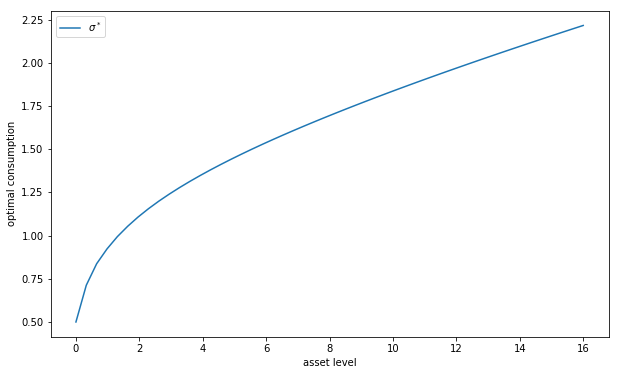

In [6]:
cp = ConsumerProblem()
σ_star = solve_model(cp)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cp.asset_grid, σ_star[:, 0], label='$\sigma^*$')
ax.set(xlabel='asset level', ylabel='optimal consumption')
ax.legend()
plt.show()

The following exercises walk you through several applications where policy functions are computed

## Exercises

### Exercise 1

Next let’s consider how the interest rate affects consumption

Reproduce the following figure, which shows (approximately) optimal consumption policies for different interest rates

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/ifp_policies.png" style="width:60%;height:60%">

  
- Other than `r`, all parameters are at their default values  
- `r` steps through `np.linspace(0, 0.04, 4)`  
- Consumption is plotted against assets for income shock fixed at the smallest value  


The figure shows that higher interest rates boost savings and hence suppress consumption

### Exercise 2

Now let’s consider the long run asset levels held by households

We’ll take `r = 0.03` and otherwise use default parameters

The following figure is a 45 degree diagram showing the law of motion for assets when consumption is optimal

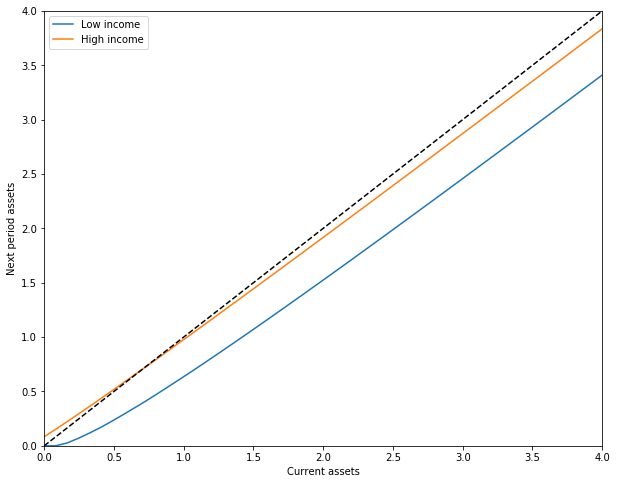

In [7]:
m = ConsumerProblem(r=0.03, grid_max=4)
K = operator_factory(m)

σ_star = solve_model(m, verbose=False)
a = m.asset_grid
R, z_vals = m.R, m.z_vals

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(a, R * a + z_vals[0] - σ_star[:, 0], label='Low income')
ax.plot(a, R * a + z_vals[1] - σ_star[:, 1], label='High income')
ax.plot(a, a, 'k--')
ax.set(xlabel='Current assets',
       ylabel='Next period assets',
       xlim=(0, 4), ylim=(0, 4))
ax.legend()
plt.show()

The blue line and orange line represent the function

$$
a' = h(a, z) := R a + z - \sigma^*(a, z)
$$

when income $ z $ takes its high and low values respectively

The dashed line is the 45 degree line

We can see from the figure that the dynamics will be stable — assets do not
diverge

In fact there is a unique stationary distribution of assets that we can calculate by simulation

- Can be proved via theorem 2 of [[HP92]](https://lectures.quantecon.org/py/zreferences.html#hopenhaynprescott1992)  
- Represents the long run dispersion of assets across households when households have idiosyncratic shocks  


Ergodicity is valid here, so stationary probabilities can be calculated by averaging over a single long time series

Hence to approximate the stationary distribution we can simulate a long time series for assets and histogram, as in the following figure

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/ifp_histogram.png" style="width:60%;height:60%">

  
Your task is to replicate the figure

- Parameters are as discussed above  
- The histogram in the figure used a single time series $ \{a_t\} $ of length 500,000  
- Given the length of this time series, the initial condition $ (a_0, z_0) $ will not matter  
- You might find it helpful to use the `MarkovChain` class from `quantecon`  

### Exercise 3

Following on from exercises 1 and 2, let’s look at how savings and aggregate asset holdings vary with the interest rate

- Note: [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012) section 18.6 can be consulted for more background on the topic treated in this exercise  


For a given parameterization of the model, the mean of the stationary distribution can be interpreted as aggregate capital in an economy with a unit mass of *ex-ante* identical households facing idiosyncratic shocks

Let’s look at how this measure of aggregate capital varies with the interest
rate and borrowing constraint

The next figure plots aggregate capital against the interest rate for `b in (1, 3)`

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/ifp_agg_savings.png" style="width:60%;height:60%">

  
As is traditional, the price (interest rate) is on the vertical axis

The horizontal axis is aggregate capital computed as the mean of the stationary distribution

Exercise 3 is to replicate the figure, making use of code from previous exercises

Try to explain why the measure of aggregate capital is equal to $ -b $
when $ r=0 $ for both cases shown here

## Solutions

### Exercise 1

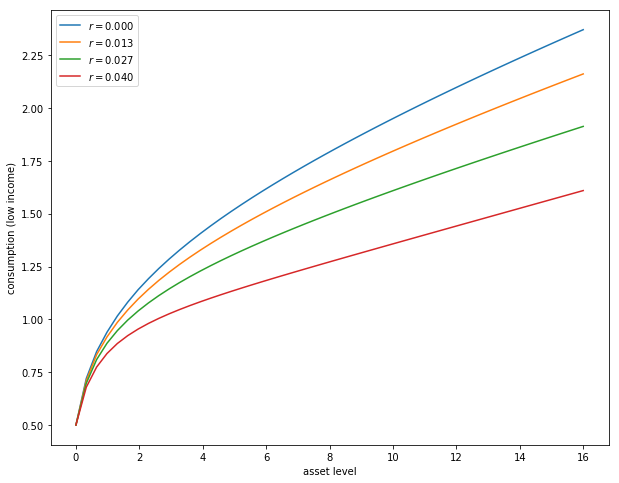

In [8]:
r_vals = np.linspace(0, 0.04, 4)

fig, ax = plt.subplots(figsize=(10, 8))
for r_val in r_vals:
    cp = ConsumerProblem(r=r_val)
    σ_star = solve_model(cp, verbose=False)
    ax.plot(cp.asset_grid, σ_star[:, 0], label=f'$r = {r_val:.3f}$')

ax.set(xlabel='asset level', ylabel='consumption (low income)')
ax.legend()
plt.show()

### Exercise 2

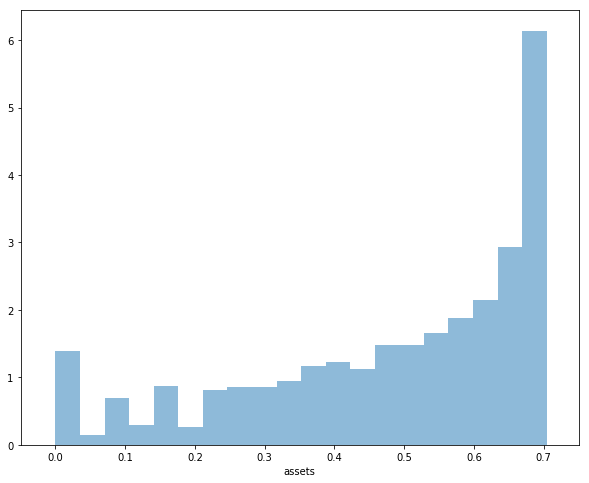

In [9]:
from quantecon import MarkovChain

def compute_asset_series(cp, T=500000, verbose=False):
    """
    Simulates a time series of length T for assets, given optimal savings
    behavior.

    cp is an instance of ConsumerProblem
    """
    Π, z_vals, R = cp.Π, cp.z_vals, cp.R  # Simplify names
    mc = MarkovChain(Π)
    σ_star = solve_model(cp, verbose=False)
    cf = lambda a, i_z: interp(cp.asset_grid, σ_star[:, i_z], a)
    a = np.zeros(T+1)
    z_seq = mc.simulate(T)
    for t in range(T):
        i_z = z_seq[t]
        a[t+1] = R * a[t] + z_vals[i_z] - cf(a[t], i_z)
    return a

cp = ConsumerProblem(r=0.03, grid_max=4)
a = compute_asset_series(cp)

fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(a, bins=20, alpha=0.5, density=True)
ax.set(xlabel='assets', xlim=(-0.05, 0.75))
plt.show()

### Exercise 3

Finished iteration b = 1


Finished iteration b = 3


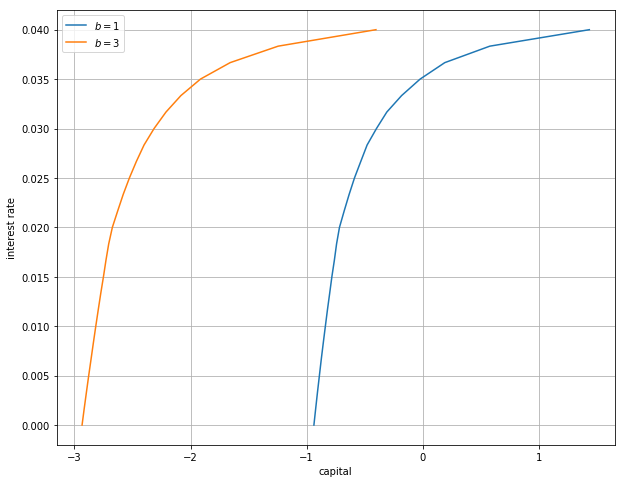

In [10]:
M = 25
r_vals = np.linspace(0, 0.04, M)
fig, ax = plt.subplots(figsize=(10, 8))

for b in (1, 3):
    asset_mean = []
    for r_val in r_vals:
        cp = ConsumerProblem(r=r_val, b=b)
        mean = np.mean(compute_asset_series(cp, T=250000))
        asset_mean.append(mean)
    ax.plot(asset_mean, r_vals, label=f'$b = {b:d}$')
    print(f"Finished iteration b = {b:d}")

ax.set(xlabel='capital', ylabel='interest rate')
ax.grid()
ax.legend()
plt.show()